# Modeling

In [2]:
import sys
import numpy as np
import pandas as pd
 
import matplotlib.pyplot as plt 
from skimage import io, util, color, transform
from sklearn import metrics

from statistics import mode
import random
from sklearn.utils import shuffle

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D

sys.path.append('./src/')
import data_utils
import img_plot

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Load training data

In [3]:
data_train_pos = np.load('./data/output/data_set/data_train_pos.npy')
data_train_pos.shape

(771, 120, 80)

In [4]:
data_train_neg = np.load('./data/output/data_set/data_train_neg.npy')
data_train_neg.shape

(3000, 120, 80)

In [5]:
data_train = np.concatenate((data_train_pos, data_train_neg), axis=0)
data_train.shape

(3771, 120, 80)

In [6]:
# create labels
y_pos = np.ones((data_train_pos.shape[0],), dtype=int)
y_neg = np.zeros((data_train_neg.shape[0],), dtype=int)
y = np.concatenate((y_pos, y_neg), axis=0)
y.shape

(3771,)

In [7]:
# shuffle data
train_set, target = shuffle(data_train, y)

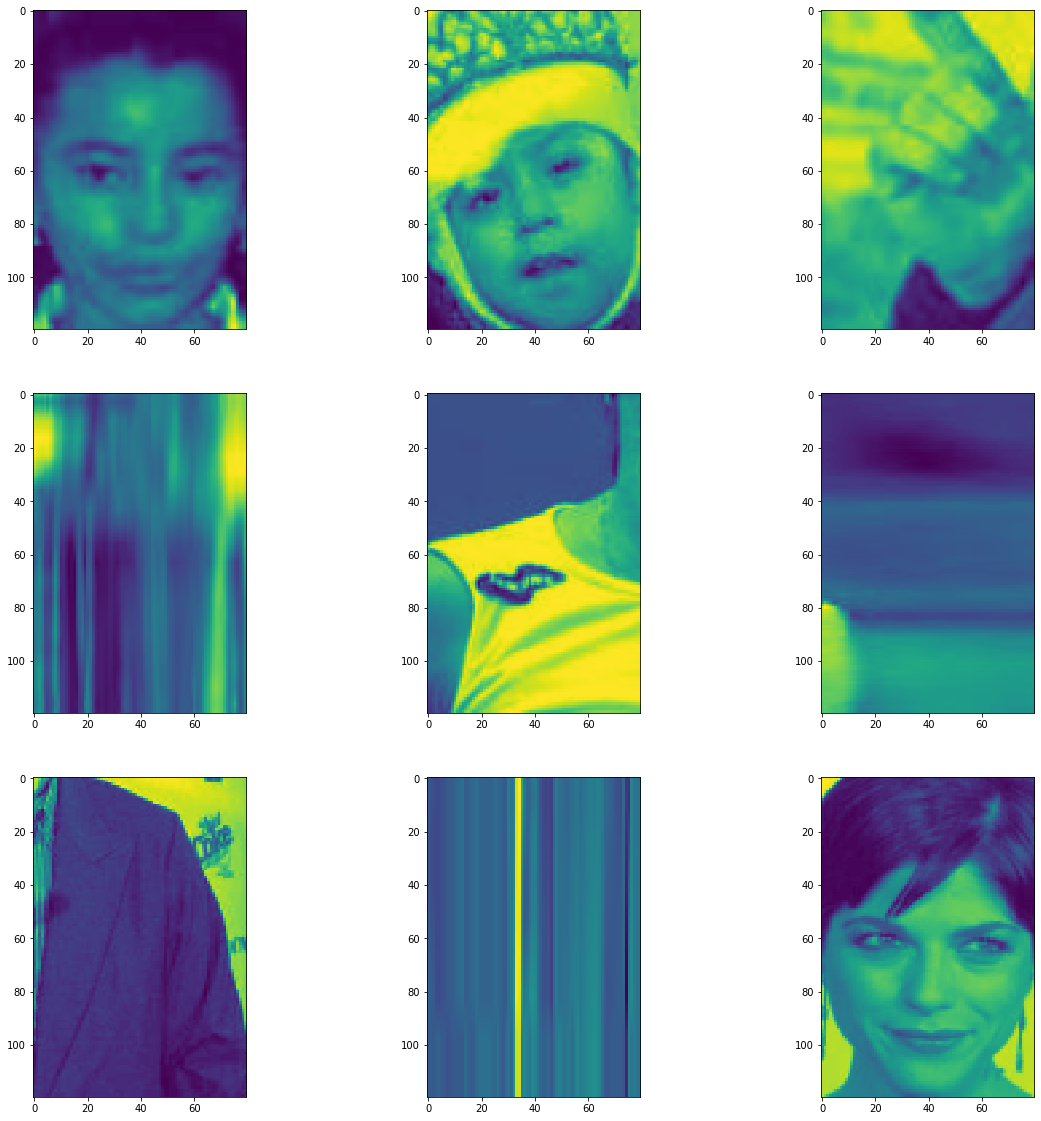

In [8]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
idx = 0
nb_sample = train_set.shape[0]
img_idx = random.sample(range(nb_sample), 9)
for i in range(3):
    for j in range(3):
        ax[i,j].imshow(train_set[img_idx[idx],:,:])
        idx += 1
plt.show()

In [9]:
target[img_idx]

array([1, 1, 0, 0, 0, 0, 0, 0, 1])

## Load validation data

In [10]:
data_validation_pos = np.load('./data/output/data_set/data_validation_pos.npy')
data_validation_pos.shape

(513, 120, 80)

In [11]:
data_validation_neg = np.load('./data/output/data_set/data_validation_neg.npy')
data_validation_neg.shape

(2000, 120, 80)

In [12]:
data_validation = np.concatenate((data_validation_pos, data_validation_neg), axis=0)
data_validation.shape

(2513, 120, 80)

In [13]:
y_validation_pos = np.ones((data_validation_pos.shape[0],), dtype=int)
y_validation_neg = np.zeros((data_validation_neg.shape[0],), dtype=int)
label_validation = np.concatenate((y_validation_pos, y_validation_neg), axis=0)
label_validation.shape

(2513,)

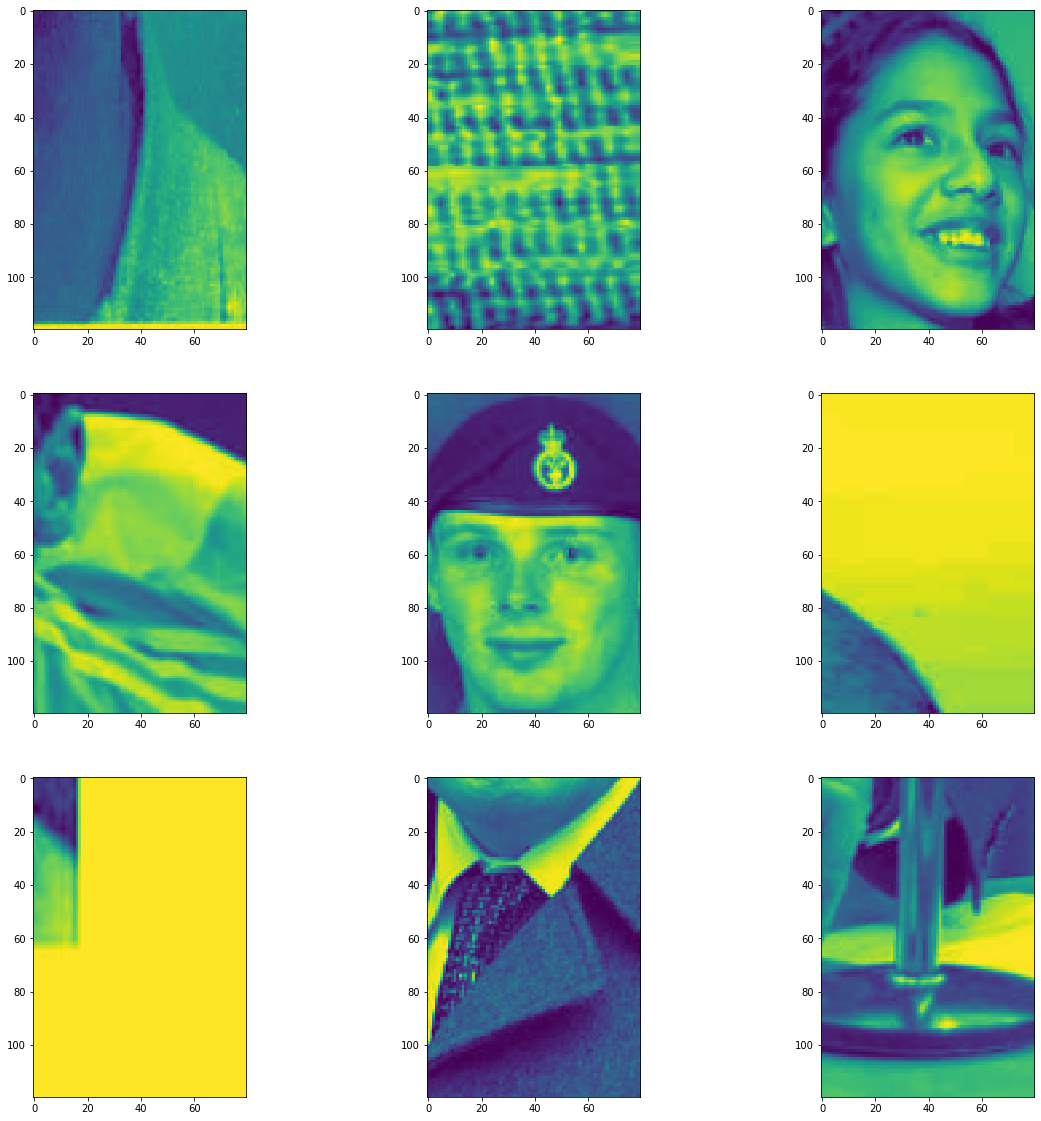

In [14]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
idx = 0
nb_sample = data_validation.shape[0]
img_idx = random.sample(range(nb_sample), 9)
for i in range(3):
    for j in range(3):
        ax[i,j].imshow(data_validation[img_idx[idx],:,:])
        idx += 1
plt.show()

In [15]:
label_validation[img_idx]

array([0, 0, 1, 0, 1, 0, 0, 0, 0])

## Modeling

In [16]:
# add the dimension of the channel
# our images are gray, so there is only one channel.
nb_sample, row, col = train_set.shape
X_train = train_set.reshape(nb_sample, row, col, 1)
X_train.shape

(3771, 120, 80, 1)

In [17]:
nb_sample, row, col = data_validation.shape
X_validation = data_validation.reshape(nb_sample, row, col, 1)
X_validation.shape

(2513, 120, 80, 1)

In [18]:
#one-hot encode target column
y_train = to_categorical(target)
y_train

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [19]:
y_validation = to_categorical(label_validation)
y_validation

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [22]:
# create model
# inspired by VGG16
model = Sequential()
model.add(Conv2D(64, (3,3), 
          activation='relu', padding='same', 
          name='block1_conv1', input_shape=(120, 80, 1)))
model.add(MaxPooling2D((2,2), strides=(2,2), name='block1_pool'))

model.add(Conv2D(128, (3,3), activation='relu', padding='same', name='block2_conv1'))
model.add(MaxPooling2D((2,2), strides=(2,2), name='block2_pool'))

model.add(Conv2D(256, (3,3), activation='relu', padding='same', name='block3_conv1'))
model.add(MaxPooling2D((2,2), strides=(2,2), name='block3_pool'))

model.add(Conv2D(256, (3,3), activation='relu', padding='same', name='block4_conv1'))
model.add(MaxPooling2D((2,2), strides=(2,2),name='block4_pool'))

model.add(Flatten())
model.add(Dense(64, activation='relu', name='fc1'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax', name='prediction'))

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 120, 80, 64)       640       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 40, 128)       73856     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 30, 20, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 30, 20, 256)       295168    
_________________________________________________________________
block3_pool (MaxPooling2D)   (None, 15, 10, 256)       0         
_________________________________________________________________
block4_conv1 (Conv2D)        (None, 15, 10, 256)       590080    
__________

In [24]:
# compile model
model.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
# train model
model.fit(X_train, y_train, validation_data=(X_validation, y_validation),
          batch_size=10, 
          epochs=6)

Train on 3771 samples, validate on 2513 samples
Epoch 1/6
3771/3771 [==============================] - 231s 61ms/step - loss: 0.5051 - acc: 0.7955 - val_loss: 0.4443 - val_acc: 0.7959
Epoch 2/6
3771/3771 [==============================] - 224s 59ms/step - loss: 0.4028 - acc: 0.8069 - val_loss: 0.3458 - val_acc: 0.8205
Epoch 3/6
3771/3771 [==============================] - 219s 58ms/step - loss: 0.3028 - acc: 0.8724 - val_loss: 0.2730 - val_acc: 0.8981
Epoch 4/6
3771/3771 [==============================] - 217s 57ms/step - loss: 0.2213 - acc: 0.9167 - val_loss: 0.1772 - val_acc: 0.9391
Epoch 5/6
3771/3771 [==============================] - 227s 60ms/step - loss: 0.1627 - acc: 0.9366 - val_loss: 0.1662 - val_acc: 0.9367
Epoch 6/6
3771/3771 [==============================] - 215s 57ms/step - loss: 0.1207 - acc: 0.9576 - val_loss: 0.1001 - val_acc: 0.9650


In [27]:
# save model
model.save('./data/models/model_v1.h5')